**Importing the Data**

In [2]:
#This cell loads the Penn Treebank corpus from nltk into a list variable named penn_treebank.
#No need to install nltk in google colab since it is preloaded in the environments.
#!pip install nltk
import nltk

#Ensure that the treebank corpus is downloaded
nltk.download('treebank')

#Load the treebank corpus class
from nltk.corpus import treebank

#Now we iterate over all samples from the corpus (the fileids - that are equivalent to sentences) 
#and retrieve the word and the pre-labeled PoS tag. This will be added as a list of tuples with 
#a list of words and a list of their respective PoS tags (in the same order).
penn_treebank = []
for fileid in treebank.fileids():
  tokens = []
  tags = []
  for word, tag in treebank.tagged_words(fileid):
    tokens.append(word)
    tags.append(tag)
  penn_treebank.append((tokens, tags))

[nltk_data] Downloading package treebank to
[nltk_data]     /home/justinrey/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [3]:
print(penn_treebank)

[(['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.', 'Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'], ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.', 'NNP', 'NNP', 'VBZ', 'NN', 'IN', 'NNP', 'NNP', ',', 'DT', 'NNP', 'VBG', 'NN', '.']), (['Rudolph', 'Agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'Consolidated', 'Gold', 'Fields', 'PLC', ',', 'was', 'named', '*-1', 'a', 'nonexecutive', 'director', 'of', 'this', 'British', 'industrial', 'conglomerate', '.'], ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', 'CC', 'JJ', 'NN', 'IN', 'NNP', 'NNP', 'NNP', 'NNP', ',', 'VBD', 'VBN', '-NONE-', 'DT', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'JJ', 'NN', '.']), (['A', 'form', 'of', 'asbestos', 'once', 'used', '*', '*', 'to', 'make', 'Kent', 'cigarette', 'filters', 'has', 'caused', 'a', 

**Extracting Features of a Sentence**

In [4]:
#Regex module for checking alphanumeric values.
import re
def extract_features(sentence, index):
  return {
      'word':sentence[index],
      'is_first':index==0,
      'is_last':index ==len(sentence)-1,
      'is_capitalized':sentence[index][0].upper() == sentence[index][0],
      'is_all_caps': sentence[index].upper() == sentence[index],
      'is_all_lower': sentence[index].lower() == sentence[index],
      'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',sentence[index])))),
      'prefix-1':sentence[index][0],
      'prefix-2':sentence[index][:2],
      'prefix-3':sentence[index][:3],
      'prefix-3':sentence[index][:4],
      'suffix-1':sentence[index][-1],
      'suffix-2':sentence[index][-2:],
      'suffix-3':sentence[index][-3:],
      'suffix-3':sentence[index][-4:],
      'prev_word':'' if index == 0 else sentence[index-1],
      'next_word':'' if index < len(sentence) else sentence[index+1],
      'has_hyphen': '-' in sentence[index],
      'is_numeric': sentence[index].isdigit(),
      'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
  }

**Data Pre-Processing**

In [5]:
#Ater defining the extract_features, we define a simple function to transform our data in a more 'datasetish' format.
#This function returns the data as two lists, one of Dicts of features and the other with the labels.
def transform_to_dataset(tagged_sentences):
  X, y = [], []
  for sentence, tags in tagged_sentences:
    sent_word_features, sent_tags = [],[]
    for index in range(len(sentence)):
        sent_word_features.append(extract_features(sentence, index)),
        sent_tags.append(tags[index])
    X.append(sent_word_features)
    y.append(sent_tags)
  return X, y

#We divide the set BEFORE encoding. Why? To have full sentences in training/testing sets. When we encode, we do not encode
#a sentence, but its words instead.

#First, for the Penn treebank.
penn_train_size = int(0.7*len(penn_treebank))
penn_validate_size = int(0.15*len(penn_treebank))
penn_test_size = int(0.15*len(penn_treebank))

penn_training = penn_treebank[:penn_train_size]
penn_validating = penn_treebank[:penn_validate_size]
penn_testing = penn_treebank[:penn_test_size]

X_penn_train, y_penn_train = transform_to_dataset(penn_training)
X_penn_val, y_penn_val = transform_to_dataset(penn_validating)
X_penn_test, y_penn_test = transform_to_dataset(penn_testing)

**Training the Data**

In [6]:
#Ignoring some warnings for the sake of readability.
import warnings
warnings.filterwarnings('ignore')

#First, install sklearn_crfsuite, as it is not preloaded into Colab. 
#!pip install sklearn_crfsuite
from sklearn_crfsuite import CRF

#This loads the model. Specifics are: 
#algorithm: methodology used to check if results are improving. Default is lbfgs (gradient descent).
#c1 and c2:  coefficients used for regularization.
#max_iterations: max number of iterations (DUH!)
#all_possible_transitions: since crf creates a "network", of probability transition states,
#this option allows it to map even "connections" not present in the data.
penn_crf = CRF(
    algorithm= 'lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
#The fit method is the default name used by Machine Learning algorithms to start training.
print("Started training on Penn Treebank corpus!")
penn_crf.fit(X_penn_train, y_penn_train)
print("Finished training on Penn Treebank corpus!")

Started training on Penn Treebank corpus!
Finished training on Penn Treebank corpus!


In [7]:
#We'll use the sklearn_crfsuit own metrics to compute f1 score.
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
#Let's see the evaluation mterics of our training data
y_penn_pred_train=penn_crf.predict(X_penn_train)
print("F1 score on Training Data ")
print(metrics.flat_f1_score(y_penn_train, y_penn_pred_train, average='weighted',labels=penn_crf.classes_))
#Let's also calculate the metrics for Accuracy and Preciosion using flat_accuracy_score and flat_precision_score
print("Precision on Training Data")
print(metrics.flat_accuracy_score(y_penn_train, y_penn_pred_train))
print("Accuracy on Training Data")
print(metrics.flat_precision_score(y_penn_train, y_penn_pred_train, average='weighted'))
print('Recall Score on Training Data')
print(metrics.flat_recall_score(y_penn_train, y_penn_pred_train, average='weighted'))
print("Class wise score on Training Data:")
penns = metrics.flat_classification_report(y_penn_train, y_penn_pred_train, labels=penn_crf.classes_, digits=3)
print(penns)

F1 score on Training Data 
0.9928789571531375
Precision on Training Data
0.9928996329578534
Accuracy on Training Data
0.9928749473542337
Recall Score on Training Data
0.9928996329578534
Class wise score on Training Data:
              precision    recall  f1-score   support

         NNP      0.995     0.997     0.996      7490
           ,      1.000     1.000     1.000      3880
          CD      0.998     0.998     0.998      2429
         NNS      0.997     0.997     0.997      4819
          JJ      0.984     0.978     0.981      4627
          MD      1.000     1.000     1.000       707
          VB      0.993     0.986     0.990      2024
          DT      0.997     0.998     0.997      6414
          NN      0.992     0.992     0.992     10014
          IN      0.989     0.994     0.991      7719
           .      1.000     1.000     1.000      3050
         VBZ      0.999     0.997     0.998      1774
         VBG      0.984     0.980     0.982      1175
          CC      0.99

**Validating the Data**

In [8]:
#Now let's validate our model
#First calculate a prediction from test data, then we print the metrics for f-1 using the .flat_f1_score method.
y_penn_pred_val=penn_crf.predict(X_penn_val)
print("F1 score on Validation Data")
print(metrics.flat_f1_score(y_penn_val, y_penn_pred_val,average='weighted',labels=penn_crf.classes_))
#Let's also calculate the metrics for Accuracy and Preciosion using flat_accuracy_score and flat_precision_score
print("Precision on Validation Data")
print(metrics.flat_accuracy_score(y_penn_val, y_penn_pred_val))
print("Accuracy on Validation Data")
print(metrics.flat_precision_score(y_penn_val, y_penn_pred_val, average='weighted'))
print('Recall Score on Validation Data')
print(metrics.flat_recall_score(y_penn_val, y_penn_pred_val, average='weighted'))
# This presents class wise score. Helps see which classes (tags) are the ones with most problems.
penns_val = metrics.flat_classification_report(y_penn_val, y_penn_pred_val, labels=penn_crf.classes_, digits=3)
print(penns_val)

F1 score on Validation Data
0.9919059172794396
Precision on Validation Data
0.9919313524590164
Accuracy on Validation Data
0.9919990712849774
Recall Score on Validation Data
0.9919313524590164
              precision    recall  f1-score   support

         NNP      0.987     0.997     0.992       919
           ,      1.000     1.000     1.000       361
          CD      0.997     0.994     0.995       318
         NNS      1.000     1.000     1.000       494
          JJ      0.986     0.967     0.976       449
          MD      1.000     1.000     1.000        69
          VB      0.988     1.000     0.994       169
          DT      0.997     0.995     0.996       628
          NN      0.988     0.993     0.991      1001
          IN      0.990     0.987     0.989       794
           .      1.000     1.000     1.000       308
         VBZ      1.000     1.000     1.000       131
         VBG      0.981     0.990     0.986       103
          CC      1.000     0.994     0.997       

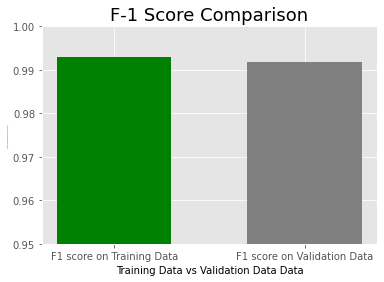

In [9]:
import numpy as np
from matplotlib import pyplot as plt

plt.style.use('ggplot')
plt.plot(range(0, 1))
width = 0.4
import matplotlib.pyplot as plt
colors = ['green','gray']
TrainingvTest = ['F1 score on Training Data', 'F1 score on Validation Data']
scores = [0.9928789571531375, 0.9919059172794396]
plt.bar(x = TrainingvTest, height = scores, width = 0.6, color=colors, align = 'center')
plt.title('F-1 Score Comparison', fontsize=18)
plt.xlabel('Training Data vs Validation Data Data', fontsize=10).set_color('black')
#This would adjust the scale of our y-axis values
plt.ylim(ymin=0.95,ymax=1)
plt.ylabel(scores, fontsize=1).set_color('black')
plt.show()

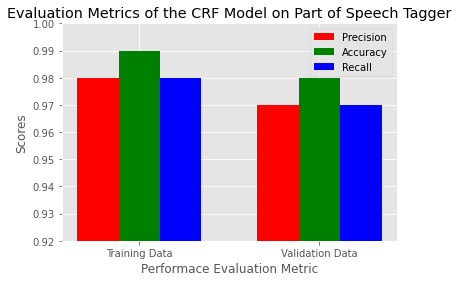

In [10]:
import numpy as np
import matplotlib.pyplot as plt
  
N = 2
ind = np.arange(N) 
width = 0.230
  
PR = [0.98, 0.97]
bar1 = plt.bar(ind, PR, width, color = 'r')
  
AC = [0.99, 0.98]
bar2 = plt.bar(ind+width, AC, width, color='g')
  
RE = [0.98, 0.97]
bar3 = plt.bar(ind+width*2, RE, width, color = 'b')

plt.ylim(ymin=0.92,ymax=1)
plt.xlabel("Performace Evaluation Metric")
plt.ylabel('Scores')
plt.title("Evaluation Metrics of the CRF Model on Part of Speech Tagger")
  
plt.xticks(ind+width,['Training Data', 'Validation Data'])
plt.legend( (bar1, bar2, bar3), ('Precision', 'Accuracy', 'Recall'), loc= 0)
plt.show()

**Hypertuning Parameters**

In [11]:
import sklearn_crfsuite
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations = 100,
    all_possible_transitions = True
)
params_space = {
    'c1' :scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=penn_crf.classes_)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_penn_train, y_penn_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 25.6min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6c2ba3ddc0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6c28590d30>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['NNP', ',', 'CD', 'NNS', 'JJ', 'MD', 'VB', 'DT', 'NN', 'IN', '.', 'VBZ', 'VBG', 'CC', 'VBD', 'VBN', '-NONE-', 'RB', 'TO', 'PRP', 'RBR', 'WDT', 'VBP', 'RP', 'PRP$', 'JJS', 'POS', '``', 'EX', "''", 'WP', ':', 'JJR', 'WRB', '$', 'NNPS', 'WP$', '-LRB-', '-RRB-', 'PDT', 'RBS', 'FW', 'UH', 'SYM', 'LS', '#']),
                   verbose=1)

In [12]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.016785933970573437, 'c2': 0.12293074313113617}
best CV score: 0.953583842936854
model size: 1.81M


**Now we try our hypertuned paramters with the test data**

In [13]:
crf = rs.best_estimator_
y_pred = crf.predict(X_penn_test)
print("F1 score on Test Data")
print(metrics.flat_f1_score(y_penn_test, y_pred,average='weighted',labels=penn_crf.classes_))
#Let's also calculate the metrics for Accuracy and Preciosion using flat_accuracy_score and flat_precision_score
print("Precision on Test Data")
print(metrics.flat_accuracy_score(y_penn_test, y_pred))
print("Accuracy on Test Data")
print(metrics.flat_precision_score(y_penn_test, y_pred, average='weighted'))
print('Recall Score on Test Data')
print(metrics.flat_recall_score(y_penn_test, y_pred, average='weighted'))
# This presents class wise score. Helps see which classes (tags) are the ones with most problems.
print(metrics.flat_classification_report(
    y_penn_test, y_pred, labels=penn_crf.classes_, digits=3
))

F1 score on Test Data
0.992291357203382
Precision on Test Data
0.9923155737704918
Accuracy on Test Data
0.9923855243841826
Recall Score on Test Data
0.9923155737704918
              precision    recall  f1-score   support

         NNP      0.987     0.997     0.992       919
           ,      1.000     1.000     1.000       361
          CD      0.997     0.994     0.995       318
         NNS      1.000     1.000     1.000       494
          JJ      0.986     0.969     0.978       449
          MD      1.000     1.000     1.000        69
          VB      0.988     1.000     0.994       169
          DT      0.997     0.997     0.997       628
          NN      0.988     0.993     0.991      1001
          IN      0.992     0.987     0.990       794
           .      1.000     1.000     1.000       308
         VBZ      1.000     1.000     1.000       131
         VBG      0.981     0.990     0.986       103
          CC      1.000     0.994     0.997       172
         VBD      0.9

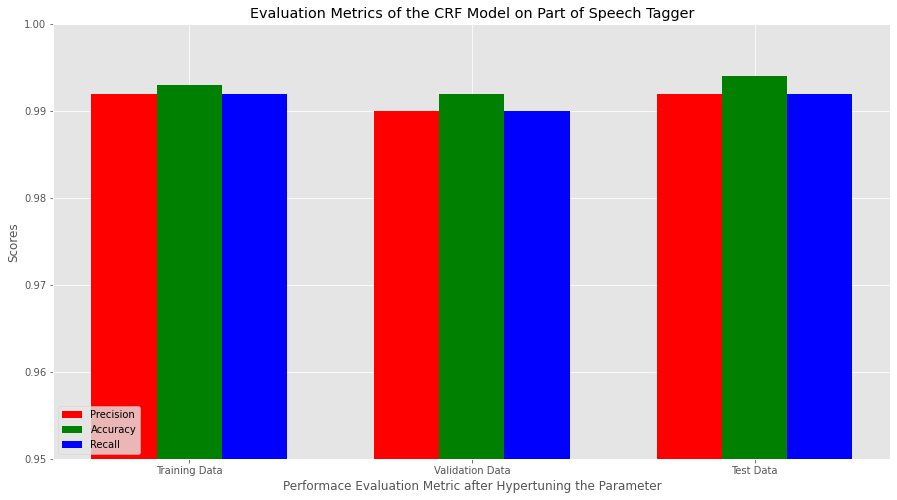

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
N = 3
ind = np.arange(N) 
width = 0.230
  
PR = [0.992, 0.990, 0.992]
bar1 = plt.bar(ind, PR, width, color = 'r')
  
AC = [0.993, 0.992, 0.994]
bar2 = plt.bar(ind+width, AC, width, color='g')
  
RE = [0.992, 0.990, 0.992]
bar3 = plt.bar(ind+width*2, RE, width, color = 'b')

plt.ylim(ymin=0.95,ymax=1)
plt.xlabel("Performace Evaluation Metric after Hypertuning the Parameter")
plt.ylabel('Scores')
plt.title("Evaluation Metrics of the CRF Model on Part of Speech Tagger")
  
plt.xticks(ind+width,['Training Data', 'Validation Data', 'Test Data'])
plt.legend( (bar1, bar2, bar3), ('Precision', 'Accuracy', 'Recall'), loc= 3)
plt.show()

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

bin_y_penn_train = MultiLabelBinarizer().fit_transform(y_penn_train)
bin_y_penn_pred_val = MultiLabelBinarizer().fit_transform(y_penn_pred_val)
bin_y_penn_test = MultiLabelBinarizer().fit_transform(y_penn_test)
bin_y_pred = MultiLabelBinarizer().fit_transform(y_pred)



from sklearn.metrics import multilabel_confusion_matrix
conmat = multilabel_confusion_matrix(bin_y_penn_test, bin_y_pred)
conmat

array([[[13,  0],
        [ 0, 16]],

       [[17,  0],
        [ 0, 12]],

       [[ 0,  0],
        [ 0, 29]],

       [[26,  0],
        [ 0,  3]],

       [[ 1,  0],
        [ 0, 28]],

       [[26,  0],
        [ 0,  3]],

       [[ 0,  0],
        [ 0, 29]],

       [[18,  0],
        [ 0, 11]],

       [[ 2,  0],
        [ 0, 27]],

       [[ 1,  0],
        [ 0, 28]],

       [[ 0,  0],
        [ 0, 29]],

       [[25,  0],
        [ 0,  4]],

       [[ 0,  0],
        [ 0, 29]],

       [[ 0,  0],
        [ 0, 29]],

       [[16,  0],
        [ 0, 13]],

       [[18,  0],
        [ 0, 11]],

       [[ 9,  0],
        [ 0, 20]],

       [[ 0,  0],
        [ 0, 29]],

       [[ 0,  0],
        [ 0, 29]],

       [[22,  0],
        [ 0,  7]],

       [[ 1,  0],
        [ 0, 28]],

       [[28,  0],
        [ 0,  1]],

       [[ 8,  0],
        [ 0, 21]],

       [[ 7,  0],
        [ 0, 22]],

       [[13,  0],
        [ 0, 16]],

       [[ 8,  0],
        [ 0, 21]],

       [[22,

In [16]:
from mlcm import mlcm

conf_mat,normal_conf_mat = mlcm.cm(bin_y_penn_test,bin_y_penn_pred_val)
rawmconf = (conf_mat)
print('\nRaw confusion Matrix:')
print(conf_mat)
normconf = (normal_conf_mat)
print('\nNormalized confusion Matrix (%):')
print(normal_conf_mat)

one_vs_rest = mlcm.stats(conf_mat)

MLCM has one extra row (NTL) and one extra column (NPL).        
Please read the following paper for more information:
        Heydarian et al., MLCM: Multi-Label Confusion Matrix, IEEE Access,2022        
To skip this message, please add parameter "print_note=False"
        e.g., conf_mat,normal_conf_mat = mlcm.cm(label_true,label_pred,False)

Raw confusion Matrix:
[[16  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0 29 ...  0  0  0]
 ...
 [ 0  0  0 ...  4  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0  0]]

Normalized confusion Matrix (%):
[[100.   0.   0. ...   0.   0.   0.]
 [  0. 100.   0. ...   0.   0.   0.]
 [  0.   0. 100. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 100.   0.   0.]
 [  0.   0.   0. ...   0. 100.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
[[[690   0]
  [  0  16]]

 [[694   0]
  [  0  12]]

 [[677   0]
  [  0  29]]

 [[703   0]
  [  0   3]]

 [[678   0]
  [  0  28]]

 [[703   0]
  [  0   3]]

 [[677   0]
  [  0  29]]

 [[695   0]
  [  0  11]]

 [[67

In [1]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf_mat, range(41), range(41))
plt.figure(figsize=(30,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap = 'Blues') # font size

plt.show()

NameError: name 'conf_mat' is not defined

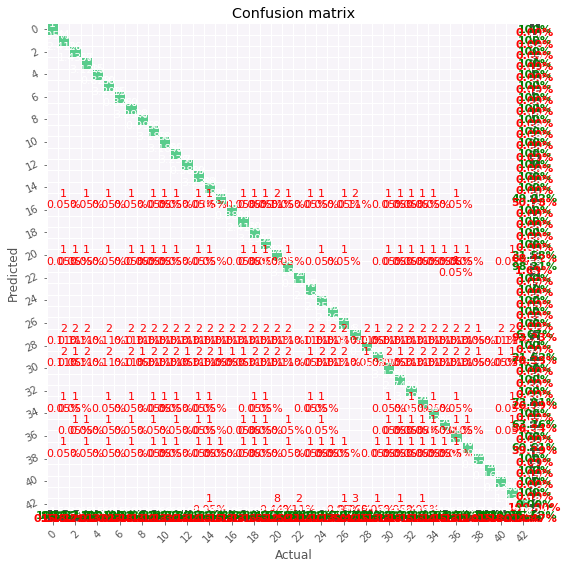

In [31]:
import numpy as np
from pretty_confusion_matrix import pp_matrix

# get pandas dataframe
df_cm = pd.DataFrame(rawmconf, index=range(0, 43), columns=range(0, 43))
# colormap: see this and choose your more dear
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

In [ ]:
#First, we pass the sentence and "quickly tokenize it" - we've already done it in our code, so I'll just mock here with a split:
sent = "Justin definitely loves Ava so much"
features = [extract_features(sent.split(), idx) for idx in range(len(sent.split()))]

#Then we tell the algorithm to make a prediction on a single input (sentence). I'll do once for Penn Treebank and once for UD.
penn_results = penn_crf.predict_single(features)

#These line magics are just there to make it a neaty print, making a (word, POS) style print;
penn_tups = [(sent.split()[idx], penn_results[idx]) for idx in range(len(sent.split()))]

#The results come out here! Notice the difference in tags.
print(penn_tups)

In [ ]:
import pickle

test = "The quick brown fox jumps over"
features = [extract_features(test.split(), idx) for idx in range(len(test.split()))]
pickled_model = pickle.load(open('penn_treebank_crf_postagger.sav', 'rb'))
predictions_test = pickled_model.predict_single(features)
pairs_test = [(test.split()[idx], predictions_test[idx]) for idx in range(len(test.split()))]
print(pairs_test)